# PyTorch for Deep Learning - Basics
Credits:
- PyTorch for Deep Learning - Full Course / Tutorial [freeCodeCamp](https://www.youtube.com/watch?v=GIsg-ZUy0MY&t=21636s)

## 0. Data

In [2]:
import numpy as np
import torch

# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70], 
                   [74, 66, 43], 
                   [91, 87, 65], 
                   [88, 134, 59], 
                   [101, 44, 37], 
                   [68, 96, 71], 
                   [73, 66, 44], 
                   [92, 87, 64], 
                   [87, 135, 57], 
                   [103, 43, 36], 
                   [68, 97, 70]], 
                  dtype='float32')

# Targets (apples, oranges)
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119],
                    [57, 69], 
                    [80, 102], 
                    [118, 132], 
                    [21, 38], 
                    [104, 118], 
                    [57, 69], 
                    [82, 100], 
                    [118, 134], 
                    [20, 38], 
                    [102, 120]], 
                   dtype='float32')

inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

## 1. Linear Regression in numpy -- 1 hidden layer 2 neurons

In [3]:
import numpy as np

# model
def model(x): return x @ w.t() + b

# model parameters
w = torch.randn(2,3, requires_grad=True) # 2x3
b = torch.randn(2, requires_grad=True) # 1x2

# loss function
def mse(t1, t2):
    diff = t1-t2
    return torch.sum(diff**2)/diff.numel()

# optimizer - update weights and biases 
# epochs - optimize multiple times
for i in range(1000):
    preds = model(inputs)
    loss = mse(preds, targets)
    loss.backward()
    with torch.no_grad():
        w -= w.grad * 1e-5
        b -= b.grad * 1e-5
        w.grad.zero_()
        b.grad.zero_()
        
print(loss, targets.mean())

tensor(11.0964, grad_fn=<DivBackward0>) tensor(84.)


## 2. Linear Regression in pytorch -- 1 hidden layer 2 neurons

In [4]:
# import torch and its methods
import torch
import torch.nn as nn               # More of OOPing
import torch.nn.functional as F     # More of functions
import torch.optim as optim

from torch.utils.data import TensorDataset 
from torch.utils.data import DataLoader

# DataLoader
train_ds = TensorDataset(inputs, targets)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)

# model + model params
model = nn.Linear(3,2)

# loss fucntion
mse = F.mse_loss

# optimizer
opt = optim.SGD(model.parameters(), lr=1e-5)

# update weights and biases multiple times
def fit(num_epochs, model, loss_fn, opt, train_dl):
    # Repeat for given number of epochs
    for epoch in range(num_epochs):
        
        # Train with batches of data
        for xb,yb in train_dl:
            
            # 1. Generate predictions
            pred = model(xb)
            
            # 2. Calculate loss
            loss = loss_fn(pred, yb)
            
            # 3. Compute gradients
            loss.backward()
            
            # 4. Update parameters using gradients
            opt.step()
            
            # 5. Reset the gradients to zero
            opt.zero_grad()
        
        # Print the progress
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}],Loss: {loss}, y_mean: {targets.mean()}')
            
fit(num_epochs=1000, model=model, loss_fn=mse, opt=opt, train_dl=train_dl)

Epoch [100/1000],Loss: 19.976354598999023, y_mean: 84.0
Epoch [200/1000],Loss: 9.596784591674805, y_mean: 84.0
Epoch [300/1000],Loss: 5.511408805847168, y_mean: 84.0
Epoch [400/1000],Loss: 1.9738044738769531, y_mean: 84.0
Epoch [500/1000],Loss: 0.9948694705963135, y_mean: 84.0
Epoch [600/1000],Loss: 0.6645762920379639, y_mean: 84.0
Epoch [700/1000],Loss: 0.9079132676124573, y_mean: 84.0
Epoch [800/1000],Loss: 0.8994174599647522, y_mean: 84.0
Epoch [900/1000],Loss: 1.2476019859313965, y_mean: 84.0
Epoch [1000/1000],Loss: 0.846535861492157, y_mean: 84.0


## 3. Image Classification with Logistic Regression (GPU)

In [4]:
# import torch and its methods
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

from timeit import default_timer as timer
from tqdm import tqdm
%matplotlib inline

print(f"numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")

# get CPU/GPU device
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
    #if 0:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
print(device)

numpy: 1.18.1
matplotlib: 3.3.4
torch: 1.1.0
torchvision: 0.3.0
cuda


In [5]:
# load dataset
dataset = datasets.MNIST(root='./data/', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data/', train=False, download=True, transform=transforms.ToTensor())

# split indices for train and val sets
def split_indices(n, val_pct):
    # size of val set
    n_val = int(val_pct*n)
    # random permutations of 0 to n-1
    idxs = np.random.permutation(n)
    # pick first n_val indices for val set
    return idxs[n_val:], idxs[:n_val]

train_indices, val_indices = split_indices(n=len(dataset), val_pct=0.2)

batch_size = 128

# training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
# validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

# testing data loader


In [6]:
# an all in one model class -- including helper functions as methods
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        # initialise the parent class (Module) __init__ method
        super().__init__()
        # hidden layer 1 [hidLyr1]
        self.hidLyr1 = nn.Linear(in_size, hidden_size)
        # hidden layer 2 [hidLyr2]
        self.hidLyr2 = nn.Linear(hidden_size, hidden_size)
        # output layer   [outLyr]
        self.outLyr = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.hidLyr1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer
        out = self.hidLyr2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.outLyr(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self.forward(images)          # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self.forward(images)            # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [76]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        # for batch in tqdm(train_loader):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [77]:
# move model or data to chosen device
# preferably for one time use
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# move data to device on the fly (only when it is about to be used)
# used for batches
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):  # called when dl is used in a for loop
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device) # return when needed (called)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [78]:
# wrap data loaders using DeviceDataLoader
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

# define model
input_size = 28*28 # number of features
num_classes = 10   # number of all possible labels
hidden_size = 32   # you can change this

model = MnistModel(in_size=input_size, hidden_size=32, out_size=num_classes)
to_device(model, device)
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([32, 32])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [79]:
# train the model
history = [evaluate(model, val_loader)]
start = timer()
history += fit(10, 0.5, model, train_loader, val_loader)
end = timer()
print('Time: ',end-start, ' s')

  1%|          | 4/375 [00:00<00:10, 34.85it/s]

Epoch [0], val_loss: 0.2077, val_acc: 0.9381


  1%|          | 4/375 [00:00<00:10, 35.32it/s]

Epoch [1], val_loss: 0.1808, val_acc: 0.9445


 57%|█████▋    | 213/375 [00:06<00:04, 35.40it/s]


KeyboardInterrupt: 

Text(0, 0.5, 'accuracy')

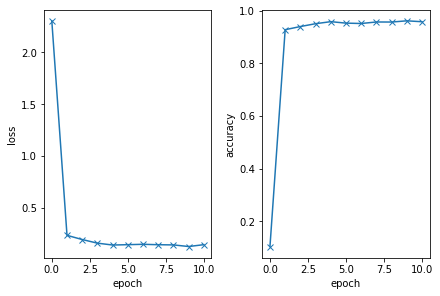

In [ ]:
# plot loss and accuracy
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True)

losses = [x['val_loss'] for x in history]
metrics = [x['val_acc'] for x in history]

ax[0].plot(losses, '-x', label='loss')
ax[1].plot(metrics, '-x', label='accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')

Label: 7 , Predicted: 7


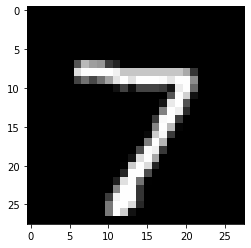

In [12]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))    

In [13]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.13566304743289948, 'val_acc': 0.9624999761581421}

In [52]:
preds = []
y_true = []
for xb, y in test_dataset:
    xb = to_device(xb.unsqueeze(0), device)
    yb = model(xb)
    _, pred  = torch.max(yb, dim=1)
    preds.append(pred[0].item())
    y_true.append(y)

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_true, preds))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.97      0.98      1135
           2       0.97      0.93      0.95      1032
           3       0.95      0.95      0.95      1010
           4       0.97      0.95      0.96       982
           5       0.94      0.96      0.95       892
           6       0.99      0.96      0.97       958
           7       0.94      0.98      0.96      1028
           8       0.94      0.97      0.95       974
           9       0.94      0.96      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

